In [3]:
%matplotlib inline
import sys

PATH = '/Users/samuele/University/2.DM2/DataMining-2/fma_metadata/'
sys.path.insert(0, PATH) 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from IPython.display import display

import utils
from collections import defaultdict

In [4]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)
    

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

# Data Preparation

In [17]:
df = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/echo_popelec.csv')
df.set_index('track_id', inplace=True)
display(df.head())
display(df['genre_top'].value_counts())

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.963590,111.562,161,192,Pop
213,0.933741,0.312720,0.340999,0.919242,0.082976,0.032745,0.043054,142.499,247,256,Pop
384,0.444822,0.561166,0.700912,0.817286,0.111111,0.036441,0.344763,91.077,249,256,Electronic
386,0.436375,0.585549,0.782927,0.894428,0.142187,0.047893,0.301543,130.464,357,256,Electronic
387,0.464508,0.493599,0.552749,0.736318,0.110117,0.055116,0.221480,136.255,326,256,Electronic


Electronic    2049
Pop            337
Name: genre_top, dtype: int64

# Data Partitioning

In [6]:
attributes = [col for col in df.columns if col != 'genre_top']

X = df[attributes]
y = df['genre_top']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [7]:
# encoding labels
le = preprocessing.LabelEncoder()
y_test_enc = ~le.fit_transform(y_test).astype('bool')

In [8]:
df['genre_top'].value_counts()

Electronic    2049
Pop            337
Name: genre_top, dtype: int64

# RIPPER
## Pop - Electronic classifier

https://github.com/imoscovitz/wittgenstein

In [9]:
#pip install wittgenstein

In [10]:
import wittgenstein as lw

In [16]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        clf = lw.RIPPER(random_state=42, prune_size=pr)
        clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')
        y_predicted = clf.predict(X_test)
        print("prune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))

prune_size:  0.1
              precision    recall  f1-score   support

       False       0.31      0.55      0.39       100
        True       0.92      0.80      0.85       616

    accuracy                           0.76       716
   macro avg       0.61      0.67      0.62       716
weighted avg       0.83      0.76      0.79       716

prune_size:  0.2
              precision    recall  f1-score   support

       False       0.27      0.72      0.40       100
        True       0.94      0.69      0.80       616

    accuracy                           0.69       716
   macro avg       0.61      0.70      0.60       716
weighted avg       0.85      0.69      0.74       716

prune_size:  0.3
              precision    recall  f1-score   support

       False       0.20      0.84      0.33       100
        True       0.95      0.46      0.62       616

    accuracy                           0.52       716
   macro avg       0.57      0.65      0.47       716
weighted avg       0.84

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

In [18]:
clf = lw.RIPPER(random_state=42, prune_size=0.1)
clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')

In [19]:
y_predicted = clf.predict(X_test)
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.31      0.55      0.39       100
        True       0.92      0.80      0.85       616

    accuracy                           0.76       716
   macro avg       0.61      0.67      0.62       716
weighted avg       0.83      0.76      0.79       716



In [20]:
clf.out_model()

[[bit_rate=160-192 ^ acousticness=0.22-0.36] V
[duration=418-900] V
[bit_rate=160-192] V
[valence=0.01-0.05] V
[speechiness=0.2-0.65] V
[speechiness=0.11-0.2] V
[speechiness=0.07-0.08] V
[speechiness=0.08-0.11] V
[instrumentalness=0.93-0.95] V
[valence=0.05-0.13] V
[instrumentalness=0.76-0.83] V
[instrumentalness=0.83-0.86] V
[bit_rate=256-320 ^ energy=0.54-0.63]]


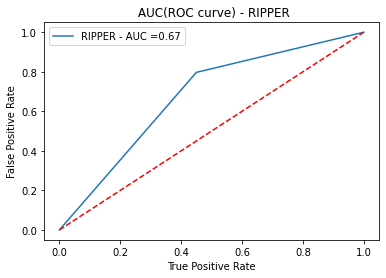

In [21]:
plot_roc_curve(y_test_enc, y_predicted, 'RIPPER')

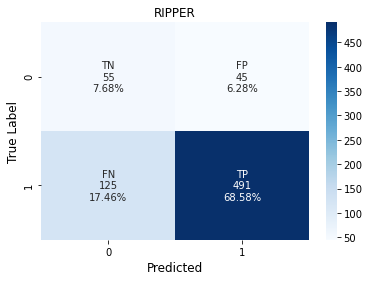

In [22]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'RIPPER')

# IREP

In [24]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        irep_clf = lw.IREP(random_state=42, prune_size=pr)
        irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')
        y_predicted = irep_clf.predict(X_test)
        print("\nprune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))


prune_size:  0.1
              precision    recall  f1-score   support

       False       0.36      0.54      0.43       100
        True       0.92      0.84      0.88       616

    accuracy                           0.80       716
   macro avg       0.64      0.69      0.66       716
weighted avg       0.84      0.80      0.82       716


prune_size:  0.2
              precision    recall  f1-score   support

       False       0.36      0.48      0.41       100
        True       0.91      0.86      0.88       616

    accuracy                           0.81       716
   macro avg       0.63      0.67      0.65       716
weighted avg       0.83      0.81      0.82       716


prune_size:  0.3
              precision    recall  f1-score   support

       False       0.51      0.25      0.34       100
        True       0.89      0.96      0.92       616

    accuracy                           0.86       716
   macro avg       0.70      0.61      0.63       716
weighted avg       0

irep.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is universal. All predictions it makes with method .predict will be positive. It may be untrained or was trained on a dataset split lacking negative examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is universal. All predictions it makes with method .predict will be positive. It may be untrained or was trained on a dataset split lacking negative examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

In [26]:
irep_clf = lw.IREP(random_state=42, prune_size=0.1)
irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')

In [27]:
y_predicted = irep_clf.predict(X_test)

In [28]:
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.36      0.54      0.43       100
        True       0.92      0.84      0.88       616

    accuracy                           0.80       716
   macro avg       0.64      0.69      0.66       716
weighted avg       0.84      0.80      0.82       716



In [29]:
irep_clf.out_model()

[[bit_rate=160-192] V
[duration=418-900] V
[duration=328-418] V
[instrumentalness=0.93-0.95] V
[tempo=85.0-93.32] V
[energy=0.94-1.0] V
[instrumentalness=0.83-0.86] V
[speechiness=0.11-0.2] V
[speechiness=0.2-0.65] V
[speechiness=0.07-0.08] V
[speechiness=0.06-0.07] V
[speechiness=0.08-0.11] V
[speechiness=0.04-0.05]]


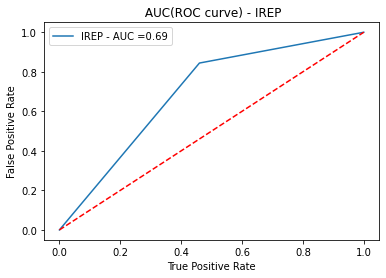

In [30]:
plot_roc_curve(y_test_enc, y_predicted, 'IREP')

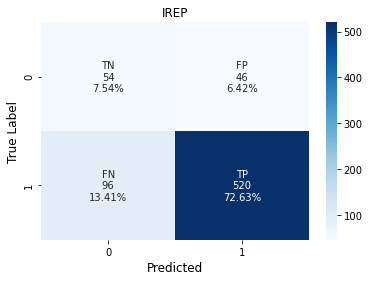

In [31]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'IREP')

# ----------------------------------------------------------------------------------------- #

# Electronic - Classical classifier

In [7]:
# load dataset with echonest features
df = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/echonest.csv')

# load tracks 
tracks = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/tracks.csv')
# select bit_rate and duration 
subselection_tracks = tracks['track'][['bit_rate', 'duration']]

In [8]:
# select genres Classical and Electronic 
genres_subset = ['Classical', 'Electronic']
labels = tracks[tracks['track']['genre_top'].isin(genres_subset)]
labels = labels['track']['genre_top']

# adjust values of bit_rate
subselection_tracks['bit_rate'] = subselection_tracks['bit_rate']/1000
# drop bit_rate with values == -1
subselection_tracks.drop(index = subselection_tracks[subselection_tracks['bit_rate']==-1].index, axis=0, inplace=True)

In [9]:
# merge datasets
df = df['echonest','audio_features'].merge(subselection_tracks, on='track_id')
df = df.merge(labels, on='track_id')
#drop missing values
df.dropna(inplace=True)
#display dataset
df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,bit_rate,duration,genre_top
track_id,,,,,,,,,,,
384,0.444822,0.561166,0.700912,0.817286,0.111111,0.036441,91.077,0.344763,256.0,249,Electronic
386,0.436375,0.585549,0.782927,0.894428,0.142187,0.047893,130.464,0.301543,256.0,357,Electronic
387,0.464508,0.493599,0.552749,0.736318,0.110117,0.055116,136.255,0.221480,256.0,326,Electronic
396,0.844582,0.144217,0.627557,0.868801,0.386048,0.091710,94.035,0.031676,256.0,1137,Electronic
397,0.625136,0.219944,0.167367,0.764413,0.349105,0.055938,74.391,0.093487,256.0,240,Electronic
...,...,...,...,...,...,...,...,...,...,...,...
122050,0.008933,0.556812,0.614484,0.847988,0.110840,0.039487,120.010,0.038668,320.0,330,Electronic
122999,0.011943,0.474490,0.728996,0.010313,0.083975,0.046229,117.968,0.275945,320.0,270,Electronic
123000,0.104619,0.459363,0.578107,0.376537,0.634532,0.029962,129.932,0.117229,320.0,283,Electronic


In [10]:
# genre_top was of type Categorical and displayed also genres with count 0.
# converting it into string fixes the problem
df['genre_top'] = df['genre_top'].astype(str)

In [11]:
# display count
df['genre_top'].value_counts()

Electronic    2170
Classical      265
Name: genre_top, dtype: int64

### Removing outliers

In [12]:
from sklearn.ensemble import IsolationForest

In [13]:
F0 = IsolationForest(random_state=42, n_estimators=300, contamination=0.06).fit(df.iloc[:,:10]) 
outliers_sk = F0.predict(df.iloc[:,:10])

In [14]:
df['outlier_IF_sklearn'] = outliers_sk
df['outlier_IF_sklearn'] = df['outlier_IF_sklearn'].apply(lambda x: 'inlier' if x==1 else 'outlier')

In [15]:
df.drop(index=df[df['outlier_IF_sklearn']=='outlier'].index, axis=0, inplace=True)

In [16]:
# count after removing 6% of outliers
df.genre_top.value_counts()

Electronic    2071
Classical      217
Name: genre_top, dtype: int64

### View data distribution

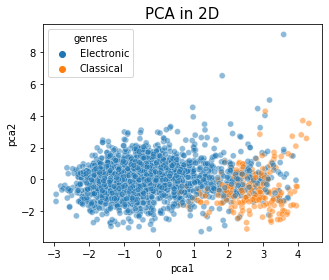

In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(df.iloc[:,:10])
scaled_df = scaler.transform(df.iloc[:,:10])

pca =PCA(2, random_state=42)
pca.fit(scaled_df)
df_pca = pca.transform(scaled_df)

df_graph = pd.DataFrame()
df_graph['pca1'] = df_pca[:,0]
df_graph['pca2'] = df_pca[:,1]
df_graph['genres'] = df['genre_top'].values

# plot scatter of PCA
plt.figure(figsize=(5,4))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    data=df_graph,
    legend="full",
    alpha=0.5
)

plt.title("PCA in 2D", fontsize= 15)
plt.show()

In [ ]:
########################################################################################################

In [19]:
df = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/echo_eleclass_noout.csv')
df.set_index('track_id', inplace=True)
display(df.head())
display(df.shape)
display(df['genre_top'].value_counts())

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
384,0.444822,0.561166,0.700912,0.817286,0.111111,0.036441,0.344763,91.077,249,256,Electronic
386,0.436375,0.585549,0.782927,0.894428,0.142187,0.047893,0.301543,130.464,357,256,Electronic
387,0.464508,0.493599,0.552749,0.736318,0.110117,0.055116,0.221480,136.255,326,256,Electronic
396,0.844582,0.144217,0.627557,0.868801,0.386048,0.091710,0.031676,94.035,1137,256,Electronic
397,0.625136,0.219944,0.167367,0.764413,0.349105,0.055938,0.093487,74.391,240,256,Electronic


(2266, 11)

Electronic    2058
Classical      208
Name: genre_top, dtype: int64

# Data Partitioning

In [20]:
# partitioning trainig set
X = df.iloc[:,:10]
# extracting labels
y = df['genre_top']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
# encoding labels in type bool - RIPPER takes only boolean values as labels
le = preprocessing.LabelEncoder()
y_test_enc = ~le.fit_transform(y_test).astype('bool')
y_train_enc = ~le.fit_transform(y_train).astype('bool')

In [22]:
#help(lw.RIPPER)

# RIPPER

With pos_class == 'Classical' the scores are low for both classes.
If pos_class == 'Electronic' RIPPER tries to maximize Classical (it can be seen when the pruning is 1, the recall for False which is Classical, is equal to 100%)

In [24]:
for pr in [0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        clf = lw.RIPPER(random_state=42, prune_size=pr)
        clf.fit(X_train, y_train, pos_class='Classical')
        y_predicted = clf.predict(X_test)
        print("prune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))

prune_size:  0.1
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       618
        True       0.82      0.82      0.82        62

    accuracy                           0.97       680
   macro avg       0.90      0.90      0.90       680
weighted avg       0.97      0.97      0.97       680

prune_size:  0.15
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       618
        True       0.81      0.69      0.75        62

    accuracy                           0.96       680
   macro avg       0.89      0.84      0.86       680
weighted avg       0.96      0.96      0.96       680

prune_size:  0.2
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       618
        True       0.80      0.79      0.80        62

    accuracy                           0.96       680
   macro avg       0.89      0.89      0.89       680
weighted avg       0.9

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

#### Retrain best model

In [25]:
clf = lw.RIPPER(random_state=42, prune_size=0.5)
clf.fit(X_train, y_train, pos_class='Classical')

In [26]:
y_predicted = clf.predict(X_test)
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       618
        True       0.81      0.90      0.85        62

    accuracy                           0.97       680
   macro avg       0.90      0.94      0.92       680
weighted avg       0.97      0.97      0.97       680



#### Extract Rules

In [27]:
clf.out_model()

[[acousticness=0.99-1.0 ^ energy=0.0-0.09] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ tempo=12.75-82.95] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ valence=0.05-0.11] V
[energy=0.0-0.09 ^ acousticness=0.89-0.99 ^ instrumentalness=0.0-0.33] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ tempo=90.38-100.0] V
[acousticness=0.99-1.0 ^ valence=0.18-0.28] V
[acousticness=0.89-0.99 ^ energy=0.0-0.09 ^ liveness=0.11-0.12] V
[energy=0.09-0.29 ^ bit_rate=-1-160 ^ duration=302-349] V
[energy=0.09-0.29 ^ acousticness=0.99-1.0 ^ bit_rate=-1-160] V
[energy=0.0-0.09 ^ liveness=0.33-0.94] V
[acousticness=0.99-1.0 ^ danceability=0.37-0.45] V
[acousticness=0.89-0.99 ^ valence=0.28-0.38 ^ danceability=0.26-0.37] V
[valence=0.11-0.18 ^ danceability=0.06-0.26 ^ speechiness=0.02-0.04] V
[energy=0.09-0.29 ^ instrumentalness=0.0-0.33 ^ danceability=0.06-0.26] V
[acousticness=0.99-1.0 ^ valence=0.58-0.71]]


#### Plot ROC curve

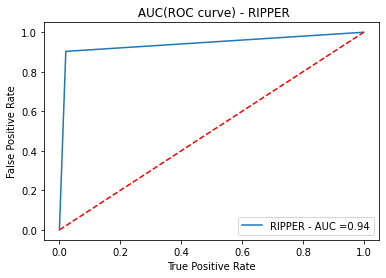

In [28]:
plot_roc_curve(y_test_enc, y_predicted, 'RIPPER')

#### Plot Confusion Matrix

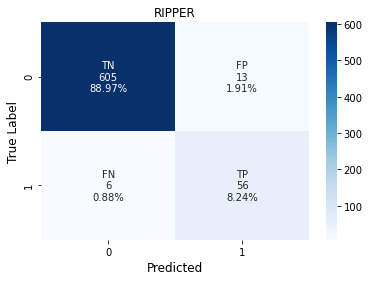

In [29]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'RIPPER')

# IREP

In [28]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        irep_clf = lw.IREP(random_state=42, prune_size=pr)
        irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Classical')
        y_predicted = irep_clf.predict(X_test)
        print("\nprune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))


prune_size:  0.1
              precision    recall  f1-score   support

       False       0.99      0.96      0.98       622
        True       0.73      0.94      0.82        65

    accuracy                           0.96       687
   macro avg       0.86      0.95      0.90       687
weighted avg       0.97      0.96      0.96       687


prune_size:  0.2
              precision    recall  f1-score   support

       False       0.99      0.96      0.98       622
        True       0.73      0.94      0.82        65

    accuracy                           0.96       687
   macro avg       0.86      0.95      0.90       687
weighted avg       0.97      0.96      0.96       687


prune_size:  0.3
              precision    recall  f1-score   support

       False       0.99      0.96      0.98       622
        True       0.73      0.94      0.82        65

    accuracy                           0.96       687
   macro avg       0.86      0.95      0.90       687
weighted avg       0

irep.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Retrain the model

In [29]:
irep_clf = lw.IREP(random_state=42, prune_size=0.55)
irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Classical')

In [30]:
y_predicted = irep_clf.predict(X_test)

In [31]:
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       622
        True       0.77      0.89      0.83        65

    accuracy                           0.97       687
   macro avg       0.88      0.93      0.90       687
weighted avg       0.97      0.97      0.97       687



In [32]:
irep_clf.out_model()

[[acousticness=0.99-1.0] V
[acousticness=0.9-0.99 ^ energy=0.0-0.08 ^ tempo=26.13-82.65]]


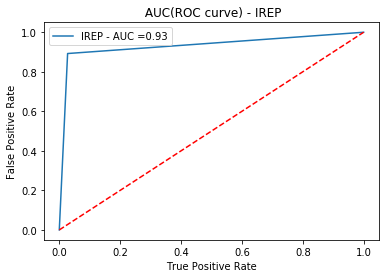

In [33]:
plot_roc_curve(y_test_enc, y_predicted, 'IREP')

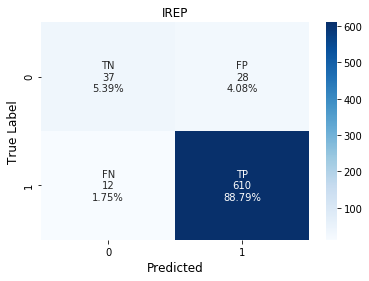

In [274]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'IREP')